In [1]:
%pip install ucimlrepo pandas numpy scikit-learn openpyxl requests


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import requests
from io import BytesIO

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from collections import defaultdict

### Download and import UC-Irvine online retail dataset

In [3]:
# Download the Online Retail dataset from UCI repository using requests
# (requests handles SSL better than urllib)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"

print("Downloading Online Retail dataset from UCI repository...")
try:
    # Use requests library which handles SSL certificates better
    response = requests.get(url, verify=False)  # verify=False bypasses SSL verification
    response.raise_for_status()
    
    # Read the Excel file from the downloaded content
    df = pd.read_excel(BytesIO(response.content), engine='openpyxl')
    print("✓ Dataset loaded successfully!")
    
    # Display dataset information
    print(f"\nDataset shape: {df.shape}")
    print(f"Rows: {df.shape[0]:,}, Columns: {df.shape[1]}")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nFirst few rows:")
    display(df.head())
    print(f"\nData types:")
    # print(df.dtypes)
    # print(f"\nBasic statistics:")
    # print(df.describe())
    
except Exception as e:
    print(f"Error: {e}")
    print("\nPlease check your internet connection or try again later.")

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'archive.ics.uci.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✓ Dataset loaded successfully!

Dataset shape: (541909, 8)
Rows: 541,909, Columns: 8

Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

First few rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



Data types:


### Preprocess into a pricing learning table

In [4]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Parse datetime
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
    df = df.dropna(subset=["InvoiceDate", "StockCode", "Quantity", "UnitPrice"])

    # Remove cancellations/returns and non-positive values
    # UCI notes InvoiceNo starting with 'C' indicates cancellation. :contentReference[oaicite:4]{index=4}
    df["InvoiceNo"] = df["InvoiceNo"].astype(str)
    df = df[~df["InvoiceNo"].str.startswith("C")]
    df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

    # Keep only products with enough observations (helps learning stability)
    df = df[df["StockCode"].astype(str).str.len() > 0]

    # Aggregate to daily product level
    df["date"] = df["InvoiceDate"].dt.date
    g = df.groupby(["StockCode", "date"], as_index=False).agg(
        qty=("Quantity", "sum"),
        price=("UnitPrice", "mean"),
        n_txn=("InvoiceNo", "nunique"),
    )

    # Add time features
    g["date"] = pd.to_datetime(g["date"])
    g["dow"] = g["date"].dt.dayofweek
    g["month"] = g["date"].dt.month

    # Lag features (per product)
    g = g.sort_values(["StockCode", "date"])
    g["qty_lag1"] = g.groupby("StockCode")["qty"].shift(1)
    g["qty_lag7"] = g.groupby("StockCode")["qty"].shift(7)

    # Fill missing lags with 0 (cold start)
    g[["qty_lag1", "qty_lag7"]] = g[["qty_lag1", "qty_lag7"]].fillna(0)

    return g

data = preprocess(df)
print(data.head())


  StockCode       date  qty  price  n_txn  dow  month  qty_lag1  qty_lag7
0     10002 2010-12-01   60  0.850      2    2     12       0.0       0.0
1     10002 2010-12-02    1  0.850      1    3     12      60.0       0.0
2     10002 2010-12-03    8  1.390      3    4     12       1.0       0.0
3     10002 2010-12-05    1  0.850      1    6     12       8.0       0.0
4     10002 2010-12-06   25  1.255      2    0     12       1.0       0.0


### Fit a simple demand model from offline data:

$$ log(1+qty) = \beta_0 + \beta_1 log(price) + context $$

In [5]:
def fit_demand_model(data: pd.DataFrame):
    d = data.copy()
    d["log_qty"] = np.log1p(d["qty"])
    d["log_price"] = np.log(d["price"])

    # identify which features are numerical and which are categorical
    features_num = ["log_price", "qty_lag1", "qty_lag7", "n_txn"]
    features_cat = ["dow", "month"]

    X = d[features_num + features_cat]
    y = d["log_qty"]

    # For numerical features, we pass them through as-is
    # For categorical features, we apply one-hot encoding
    pre = ColumnTransformer(
        transformers=[
            ("num", "passthrough", features_num),
            ("cat", OneHotEncoder(handle_unknown="ignore"), features_cat),
        ]
    )

    # Build the full pipeline with preprocessing and (Ridge)-regression model
    model = Pipeline(steps=[
        ("pre", pre),
        # ("reg", Ridge(alpha=1.0)),
        ("reg", LinearRegression()),
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
    model.fit(X_train, y_train)

    r2 = model.score(X_test, y_test)
    print(f"Demand model R^2 on log_qty: {r2:.3f}")
    return model

demand_model = fit_demand_model(data)


Demand model R^2 on log_qty: 0.470


### Build a simple Reinforcement Learning environment (model-based "offline RL")

In [ ]:
# We’ll define actions as price multipliers around the observed price:
ACTION_MULTS = np.array([0.90, 0.95, 1.00, 1.05, 1.10])

State will be a discretized tuple:
- product id
- day-of-week
- lagged-qty bin

Reward: Revenue = chosen price * simulated_qty

Transition:
- lag updates with simulated qty
- day moves forward

### Environment + Q-Learning (tabular --> simple)

In [37]:
def make_top_products(data: pd.DataFrame, top_k=200):
    """
    Get the top-k products by total quantity sold.
    """
    counts = data.groupby("StockCode")["qty"].sum().sort_values(ascending=False)
    top = counts.head(top_k).index.astype(str).tolist()
    return top

def build_episode_table(data: pd.DataFrame, top_products):
    """
    Build episode table for RL environment using only top products.
    """
    d = data[data["StockCode"].astype(str).isin(top_products)].copy()
    # Use each (product, date) row as a step; we’ll “simulate” what happens next
    d["StockCode"] = d["StockCode"].astype(str)
    d = d.sort_values(["StockCode", "date"])
    return d.reset_index(drop=True)

# Discretize lagged demand into bins
def qty_bin(q):
    # simple bins; tweak as desired
    if q < 1: return 0
    if q < 5: return 1
    if q < 10: return 2
    if q < 15: return 3
    if q < 20: return 4
    return 5

# Using the demand model, predict quantity sold given a price and row features
def predict_qty(model, row_dict, price):
    # Ensure price is positive and reasonable
    price = max(1e-6, float(price))
    
    # Check for invalid values in row_dict
    qty_lag1 = max(0.0, float(row_dict["qty_lag1"]))
    qty_lag7 = max(0.0, float(row_dict["qty_lag7"]))
    n_txn = max(1.0, float(row_dict["n_txn"]))
    
    x = {
        "log_price": np.log(price),
        "qty_lag1": qty_lag1,
        "qty_lag7": qty_lag7,
        "n_txn": n_txn,
        "dow": int(row_dict["dow"]),
        "month": int(row_dict["month"]),
    }
    X = pd.DataFrame([x])
    
    try:
        log_qty = float(model.predict(X)[0])
        # Clip log_qty to prevent extreme values
        log_qty = np.clip(log_qty, -10, 10)
        qty_hat = max(0.0, np.expm1(log_qty))
    except:
        qty_hat = 0.0
    
    return qty_hat


# -----------------------------
# 6) RL environment step
# -----------------------------
def env_step(model, row_dict, action_mult):
    """
    One-step transition:
      action_mult scales the base price
      reward is revenue = price * predicted_qty
      next_state uses qty_bin(predicted_qty)
      we update lags naively for the simulated next step
    """
    base_price = max(1e-6, float(row_dict["price"]))
    action_mult = max(0.1, min(2.0, float(action_mult)))  # Clamp action multiplier
    new_price = max(1e-6, base_price * action_mult)

    qty_hat = predict_qty(model, row_dict, new_price)
    qty_hat = max(0.0, min(10000.0, qty_hat))  # Clamp quantity to reasonable range
    
    reward = new_price * qty_hat

    next_state = qty_bin(qty_hat)

    # Update lags for next step
    next_row = dict(row_dict)
    next_row["qty_lag7"] = max(0.0, float(row_dict["qty_lag1"]))
    next_row["qty_lag1"] = max(0.0, float(qty_hat))
    next_row["price"] = new_price
    # Keep other fields stable
    next_row["n_txn"] = max(1.0, float(row_dict.get("n_txn", 1)))
    next_row["dow"] = int(row_dict["dow"])
    next_row["month"] = int(row_dict["month"])

    return next_state, reward, next_row


# -----------------------------
# 7) Q-learning
# -----------------------------
def q_learning(
    ep_table: pd.DataFrame,
    demand_model,
    actions=(0.9, 1.0, 1.1),
    episodes=3000,
    horizon=10,
    alpha=0.1,
    gamma=0.95,
    epsilon=0.2,
    seed=0,
):
    """
    Tabular Q-learning over 6 discrete states from qty_bin().
    """
    rng = np.random.default_rng(seed)

    actions = np.array(list(actions), dtype=float)
    n_states = 6  # qty_bin() returns 0-5 (6 states)
    n_actions = len(actions)
    Q = np.zeros((n_states, n_actions), dtype=float)

    for _ in range(episodes):
        # sample a random start row from ep_table
        r = ep_table.iloc[int(rng.integers(0, len(ep_table)))].to_dict()
        s = qty_bin(float(r["qty_lag1"]))

        for _t in range(horizon):
            # epsilon-greedy action
            if rng.random() < epsilon:
                a = int(rng.integers(0, n_actions))
            else:
                a = int(np.argmax(Q[s]))

            s2, reward, r = env_step(demand_model, r, actions[a])

            # Bellman update
            Q[s, a] = Q[s, a] + alpha * (reward + gamma * np.max(Q[s2]) - Q[s, a])
            s = s2

    return Q, actions


def extract_policy(Q, actions):
    """
    Return mapping: state -> best action multiplier
    """
    best_a = np.argmax(Q, axis=1)
    return {s: float(actions[a]) for s, a in enumerate(best_a)}


def run_pipeline(top_k=200, seed=0):
    TOP_PRODUCTS = make_top_products(data, top_k=top_k)
    episode_table = build_episode_table(data, TOP_PRODUCTS)
    demand_model = fit_demand_model(episode_table)
    Q, actions = q_learning(
        episode_table,
        demand_model,
        actions=ACTION_MULTS,
        episodes=3000,
        horizon=10,
        alpha=0.1,
        gamma=0.95,
        epsilon=0.2,
        seed=seed,
    )
    policy = extract_policy(Q, actions)
    return policy, Q, actions, demand_model, episode_table

policy, Q, actions, demand_model, episode_table = run_pipeline(top_k=200, seed=42)

Demand model R^2 on log_qty: 0.409


In [38]:
# Visualize the learned Q-table and policy
print("=" * 70)
print("LEARNED Q-TABLE")
print("=" * 70)
print(f"\nQ-table shape: {Q.shape}")
print(f"States: {Q.shape[0]} (quantity bins 0-5)")
print(f"Actions: {Q.shape[1]} (price multipliers)")
print(f"\nPrice multipliers: {actions}")
print(f"\nQ-values:")
print(Q)

print("\n" + "=" * 70)
print("LEARNED POLICY")
print("=" * 70)
print("\nState (qty_bin) -> Best Price Multiplier:")
for state, action_mult in policy.items():
    best_action_idx = np.argmax(Q[state])
    q_value = Q[state, best_action_idx]
    
    if state == 0:
        qty_range = "qty < 1"
    elif state == 1:
        qty_range = "1 ≤ qty < 5"
    elif state == 2:
        qty_range = "5 ≤ qty < 10"
    elif state == 3:
        qty_range = "10 ≤ qty < 15"
    elif state == 4:
        qty_range = "15 ≤ qty < 20"
    else:
        qty_range = "qty ≥ 20"
    
    print(f"  State {state} ({qty_range:15s}): price × {action_mult:.2f} (Q-value: {q_value:.2f})")

print("\n" + "=" * 70)
print("POLICY INSIGHTS")
print("=" * 70)

# Count how many states prefer each action
action_preferences = {}
for state in range(Q.shape[0]):
    best_action = np.argmax(Q[state])
    mult = actions[best_action]
    action_preferences[mult] = action_preferences.get(mult, 0) + 1

print("\nPrice multiplier distribution:")
for mult in sorted(action_preferences.keys()):
    count = action_preferences[mult]
    pct = 100 * count / Q.shape[0]
    print(f"  {mult:.2f}x: {count} states ({pct:.1f}%)")


LEARNED Q-TABLE

Q-table shape: (6, 5)
States: 6 (quantity bins 0-5)
Actions: 5 (price multipliers)

Price multipliers: [0.9  0.95 1.   1.05 1.1 ]

Q-values:
[[2172.4805404    44.41254933   55.52541002  102.77512239  176.91207679]
 [2534.06444746 2627.58409755 2042.79151971 2701.64341961 3422.85090656]
 [2841.2583698  3031.4380667  3033.65010071 2798.29688748 3022.11637906]
 [3200.30135436 2777.55925497 2959.30160716 2860.33655925 2783.72019467]
 [3587.88584265 3145.9609108  3164.03108973 3068.58041416 3083.17437881]
 [3261.12651872 3257.17129103 3259.93385295 6998.46189588 5114.72397208]]

LEARNED POLICY

State (qty_bin) -> Best Price Multiplier:
  State 0 (qty < 1        ): price × 0.90 (Q-value: 2172.48)
  State 1 (1 ≤ qty < 5    ): price × 1.10 (Q-value: 3422.85)
  State 2 (5 ≤ qty < 10   ): price × 1.00 (Q-value: 3033.65)
  State 3 (10 ≤ qty < 15  ): price × 0.90 (Q-value: 3200.30)
  State 4 (15 ≤ qty < 20  ): price × 0.90 (Q-value: 3587.89)
  State 5 (qty ≥ 20       ): price × 1.

In [ ]:
### Evaluate Policy Performance

In [39]:
def evaluate_policy(Q, actions, episode_table, demand_model, n_eval=1000, seed=42):
    """
    Evaluate the learned pricing policy vs baseline strategies.
    
    Args:
        Q: Learned Q-table
        actions: Array of action multipliers
        episode_table: DataFrame with episode data
        demand_model: Trained demand model
        n_eval: Number of evaluation episodes
        seed: Random seed for reproducibility
    
    Returns:
        Dictionary with evaluation metrics
    """
    rng = np.random.default_rng(seed)
    
    # Storage for results
    rl_revenues = []
    baseline_revenues = []
    rl_quantities = []
    baseline_quantities = []
    rl_prices = []
    baseline_prices = []
    
    for _ in range(n_eval):
        # Sample random starting state
        idx = int(rng.integers(0, len(episode_table)))
        row = episode_table.iloc[idx].to_dict()
        
        # Get state
        state = qty_bin(float(row["qty_lag1"]))
        base_price = float(row["price"])
        
        # RL Policy: use learned Q-table
        best_action = int(np.argmax(Q[state]))
        rl_mult = float(actions[best_action])
        rl_price = base_price * rl_mult
        rl_qty = predict_qty(demand_model, row, rl_price)
        rl_rev = rl_price * rl_qty
        
        rl_revenues.append(rl_rev)
        rl_quantities.append(rl_qty)
        rl_prices.append(rl_price)
        
        # Baseline: keep original price (1.0x multiplier)
        baseline_qty = predict_qty(demand_model, row, base_price)
        baseline_rev = base_price * baseline_qty
        
        baseline_revenues.append(baseline_rev)
        baseline_quantities.append(baseline_qty)
        baseline_prices.append(base_price)
    
    # Calculate metrics
    results = {
        'n_eval': n_eval,
        'rl_avg_revenue': np.mean(rl_revenues),
        'baseline_avg_revenue': np.mean(baseline_revenues),
        'rl_avg_quantity': np.mean(rl_quantities),
        'baseline_avg_quantity': np.mean(baseline_quantities),
        'rl_avg_price': np.mean(rl_prices),
        'baseline_avg_price': np.mean(baseline_prices),
        'rl_revenues': rl_revenues,
        'baseline_revenues': baseline_revenues,
        'revenue_improvement_pct': 100 * (np.mean(rl_revenues) - np.mean(baseline_revenues)) / np.mean(baseline_revenues),
        'rl_revenue_std': np.std(rl_revenues),
        'baseline_revenue_std': np.std(baseline_revenues),
    }
    
    # Print evaluation results
    print("=" * 70)
    print("POLICY EVALUATION RESULTS")
    print("=" * 70)
    print(f"\nEvaluated on {n_eval:,} random episodes\n")
    
    print("REVENUE:")
    print(f"  Baseline (original prices): ${results['baseline_avg_revenue']:8.2f} (±${results['baseline_revenue_std']:.2f})")
    print(f"  RL Policy:                  ${results['rl_avg_revenue']:8.2f} (±${results['rl_revenue_std']:.2f})")
    print(f"  Improvement:                {results['revenue_improvement_pct']:+7.2f}%")
    
    print("\nQUANTITY SOLD:")
    print(f"  Baseline:  {results['baseline_avg_quantity']:6.2f} units")
    print(f"  RL Policy: {results['rl_avg_quantity']:6.2f} units")
    qty_change = 100 * (results['rl_avg_quantity'] - results['baseline_avg_quantity']) / results['baseline_avg_quantity']
    print(f"  Change:    {qty_change:+6.2f}%")
    
    print("\nAVERAGE PRICE:")
    print(f"  Baseline:  ${results['baseline_avg_price']:6.2f}")
    print(f"  RL Policy: ${results['rl_avg_price']:6.2f}")
    price_change = 100 * (results['rl_avg_price'] - results['baseline_avg_price']) / results['baseline_avg_price']
    print(f"  Change:    {price_change:+6.2f}%")
    
    # Statistical test
    from scipy import stats
    t_stat, p_value = stats.ttest_ind(rl_revenues, baseline_revenues)
    print(f"\nSTATISTICAL SIGNIFICANCE:")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value:     {p_value:.6f}")
    if p_value < 0.05:
        print(f"  Result:      Statistically significant (p < 0.05) ✓")
    else:
        print(f"  Result:      Not statistically significant (p ≥ 0.05)")
    
    # Distribution analysis
    print(f"\nREVENUE DISTRIBUTION:")
    print(f"  Baseline - Min: ${np.min(baseline_revenues):.2f}, Max: ${np.max(baseline_revenues):.2f}, Median: ${np.median(baseline_revenues):.2f}")
    print(f"  RL Policy - Min: ${np.min(rl_revenues):.2f}, Max: ${np.max(rl_revenues):.2f}, Median: ${np.median(rl_revenues):.2f}")
    
    # Win rate
    wins = sum(1 for rl, bl in zip(rl_revenues, baseline_revenues) if rl > bl)
    win_rate = 100 * wins / n_eval
    print(f"\nWIN RATE:")
    print(f"  RL Policy beats baseline in {wins}/{n_eval} episodes ({win_rate:.1f}%)")
    
    return results


# Run evaluation
eval_results = evaluate_policy(Q, actions, episode_table, demand_model, n_eval=1000, seed=42)


POLICY EVALUATION RESULTS

Evaluated on 1,000 random episodes

REVENUE:
  Baseline (original prices): $   80.66 (±$263.15)
  RL Policy:                  $   81.35 (±$263.42)
  Improvement:                  +0.86%

QUANTITY SOLD:
  Baseline:   40.33 units
  RL Policy:  39.77 units
  Change:     -1.40%

AVERAGE PRICE:
  Baseline:  $  2.67
  RL Policy: $  2.77
  Change:     +3.95%

STATISTICAL SIGNIFICANCE:
  t-statistic: 0.059
  p-value:     0.952986
  Result:      Not statistically significant (p ≥ 0.05)

REVENUE DISTRIBUTION:
  Baseline - Min: $4.24, Max: $4633.75, Median: $30.66
  RL Policy - Min: $4.33, Max: $4426.57, Median: $31.03

WIN RATE:
  RL Policy beats baseline in 736/1000 episodes (73.6%)


### Visualize Evaluation Results

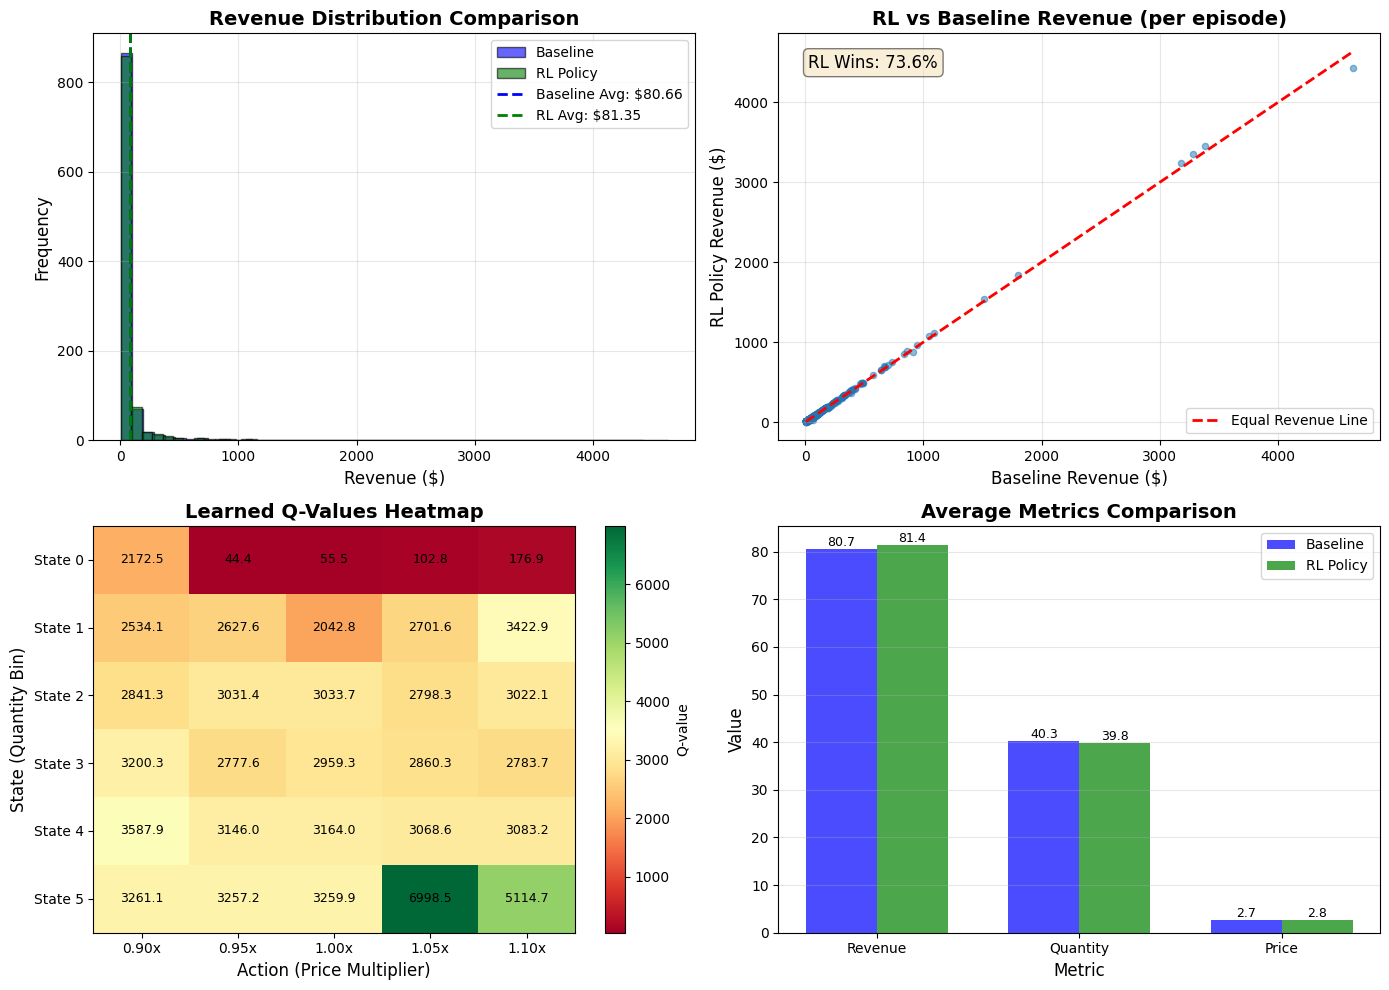


VISUALIZATION COMPLETE


In [40]:
import matplotlib.pyplot as plt

# Create visualization of evaluation results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Revenue Comparison Histogram
ax1 = axes[0, 0]
ax1.hist(eval_results['baseline_revenues'], bins=50, alpha=0.6, label='Baseline', color='blue', edgecolor='black')
ax1.hist(eval_results['rl_revenues'], bins=50, alpha=0.6, label='RL Policy', color='green', edgecolor='black')
ax1.axvline(eval_results['baseline_avg_revenue'], color='blue', linestyle='--', linewidth=2, label=f'Baseline Avg: ${eval_results["baseline_avg_revenue"]:.2f}')
ax1.axvline(eval_results['rl_avg_revenue'], color='green', linestyle='--', linewidth=2, label=f'RL Avg: ${eval_results["rl_avg_revenue"]:.2f}')
ax1.set_xlabel('Revenue ($)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Revenue Distribution Comparison', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Scatter plot: RL vs Baseline Revenue
ax2 = axes[0, 1]
ax2.scatter(eval_results['baseline_revenues'], eval_results['rl_revenues'], alpha=0.5, s=20)
max_rev = max(max(eval_results['baseline_revenues']), max(eval_results['rl_revenues']))
min_rev = min(min(eval_results['baseline_revenues']), min(eval_results['rl_revenues']))
ax2.plot([min_rev, max_rev], [min_rev, max_rev], 'r--', linewidth=2, label='Equal Revenue Line')
ax2.set_xlabel('Baseline Revenue ($)', fontsize=12)
ax2.set_ylabel('RL Policy Revenue ($)', fontsize=12)
ax2.set_title('RL vs Baseline Revenue (per episode)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Add text showing win rate
wins = sum(1 for rl, bl in zip(eval_results['rl_revenues'], eval_results['baseline_revenues']) if rl > bl)
win_rate = 100 * wins / len(eval_results['rl_revenues'])
ax2.text(0.05, 0.95, f'RL Wins: {win_rate:.1f}%', transform=ax2.transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Q-value heatmap
ax3 = axes[1, 0]
im = ax3.imshow(Q, aspect='auto', cmap='RdYlGn', interpolation='nearest')
ax3.set_xlabel('Action (Price Multiplier)', fontsize=12)
ax3.set_ylabel('State (Quantity Bin)', fontsize=12)
ax3.set_title('Learned Q-Values Heatmap', fontsize=14, fontweight='bold')
ax3.set_xticks(range(len(actions)))
ax3.set_xticklabels([f'{a:.2f}x' for a in actions])
ax3.set_yticks(range(Q.shape[0]))
ax3.set_yticklabels([f'State {i}' for i in range(Q.shape[0])])
plt.colorbar(im, ax=ax3, label='Q-value')

# Add annotations for best actions
for i in range(Q.shape[0]):
    for j in range(Q.shape[1]):
        text = ax3.text(j, i, f'{Q[i, j]:.1f}',
                       ha="center", va="center", color="black", fontsize=9)

# 4. Bar chart: Average metrics comparison
ax4 = axes[1, 1]
metrics = ['Revenue', 'Quantity', 'Price']
baseline_vals = [
    eval_results['baseline_avg_revenue'],
    eval_results['baseline_avg_quantity'],
    eval_results['baseline_avg_price']
]
rl_vals = [
    eval_results['rl_avg_revenue'],
    eval_results['rl_avg_quantity'],
    eval_results['rl_avg_price']
]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax4.bar(x - width/2, baseline_vals, width, label='Baseline', color='blue', alpha=0.7)
bars2 = ax4.bar(x + width/2, rl_vals, width, label='RL Policy', color='green', alpha=0.7)

ax4.set_xlabel('Metric', fontsize=12)
ax4.set_ylabel('Value', fontsize=12)
ax4.set_title('Average Metrics Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics)
ax4.legend()
ax4.grid(alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("VISUALIZATION COMPLETE")
print("=" * 70)
